In [1]:
from ift6758.data import wandb_handler
import ift6758.visualizations.baseline_models_figures as baseline_models_figures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np

In [2]:
artifact_name = "train_val_feature_eng_1"
data_loader = wandb_handler.DataLoader(project_name="IFT6758-2024-B05")
df_train_val = data_loader.load_all_files_from_artifact(artifact_name=artifact_name, artifact_version="v7")
df_train_val

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   4 of 4 files downloaded.  


Artifact downloaded to: ..\ift6758\data\wandb_artifacts\train_val_feature_eng_1


,season,game_id,event_id,angle,is_goal,empty_net,distance
0,20162017,2016020001,8,22.619865,0,0,13.000000
1,20162017,2016020001,11,77.005383,0,0,13.341664
2,20162017,2016020001,15,29.931512,0,0,76.157731
3,20162017,2016020001,16,14.995079,0,0,57.974132
4,20162017,2016020001,24,26.980231,0,0,61.717096
...,...,...,...,...,...,...,...
305792,20192020,2019021082,773,62.447188,0,0,25.942244
305793,20192020,2019021082,774,71.113913,0,0,40.162171
305794,20192020,2019021082,537,45.000000,0,0,14.142136
305795,20192020,2019021082,777,41.185925,0,0,10.630146


# q1

notice accuracy high but model only predicts the events are non-goals because there are more non-goal events than goals events
so the model hasn't learnt anything

logistic_regression_distance


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
wandb: Currently logged in as: andre-diler (IFT6758-2024-B05). Use `wandb login --relogin` to force relogin


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.90621
auc,0.69781
f1_score,0
precision,0
recall,0


c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


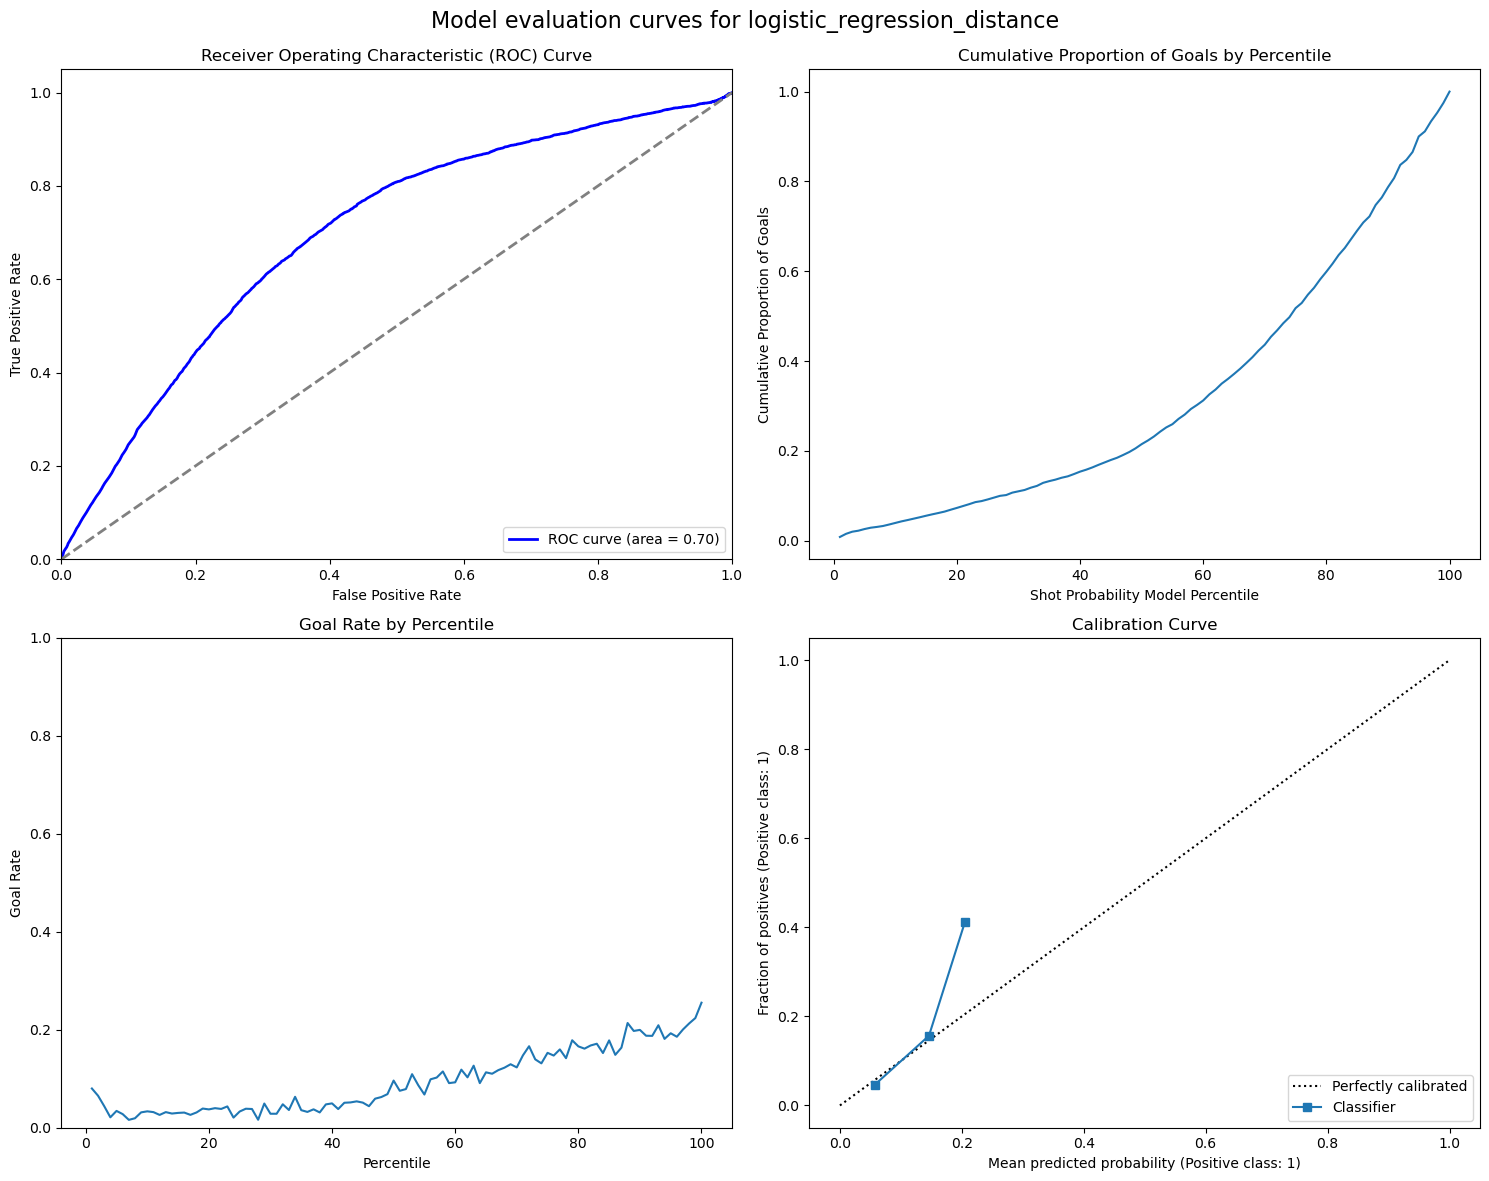

In [3]:
features = ['distance']
model_distance = LogisticRegression()
model_name = "logistic_regression_" + "_".join(features)
print(model_name)
model_handler = wandb_handler.ModelHandler()

X = df_train_val[features].to_numpy().reshape(-1, 1)
y = df_train_val['is_goal'].to_numpy().reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model_distance.fit(X_train, y_train)
model_handler.dump(model=model_distance, model_name=model_name)

y_pred_discrete, y_pred_proba = model_handler.predict(model_distance, X_val)
model_handler.get_metrics(y_pred_discrete, y_pred_proba, y_val)

model_handler.log_wandb(model_name, X_val, y_val, features)

baseline_models_figures.plot_figures(y_pred_proba, y_val, model_name)


logistic_regression_angle


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.90621
auc,0.56507
f1_score,0
precision,0
recall,0


c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


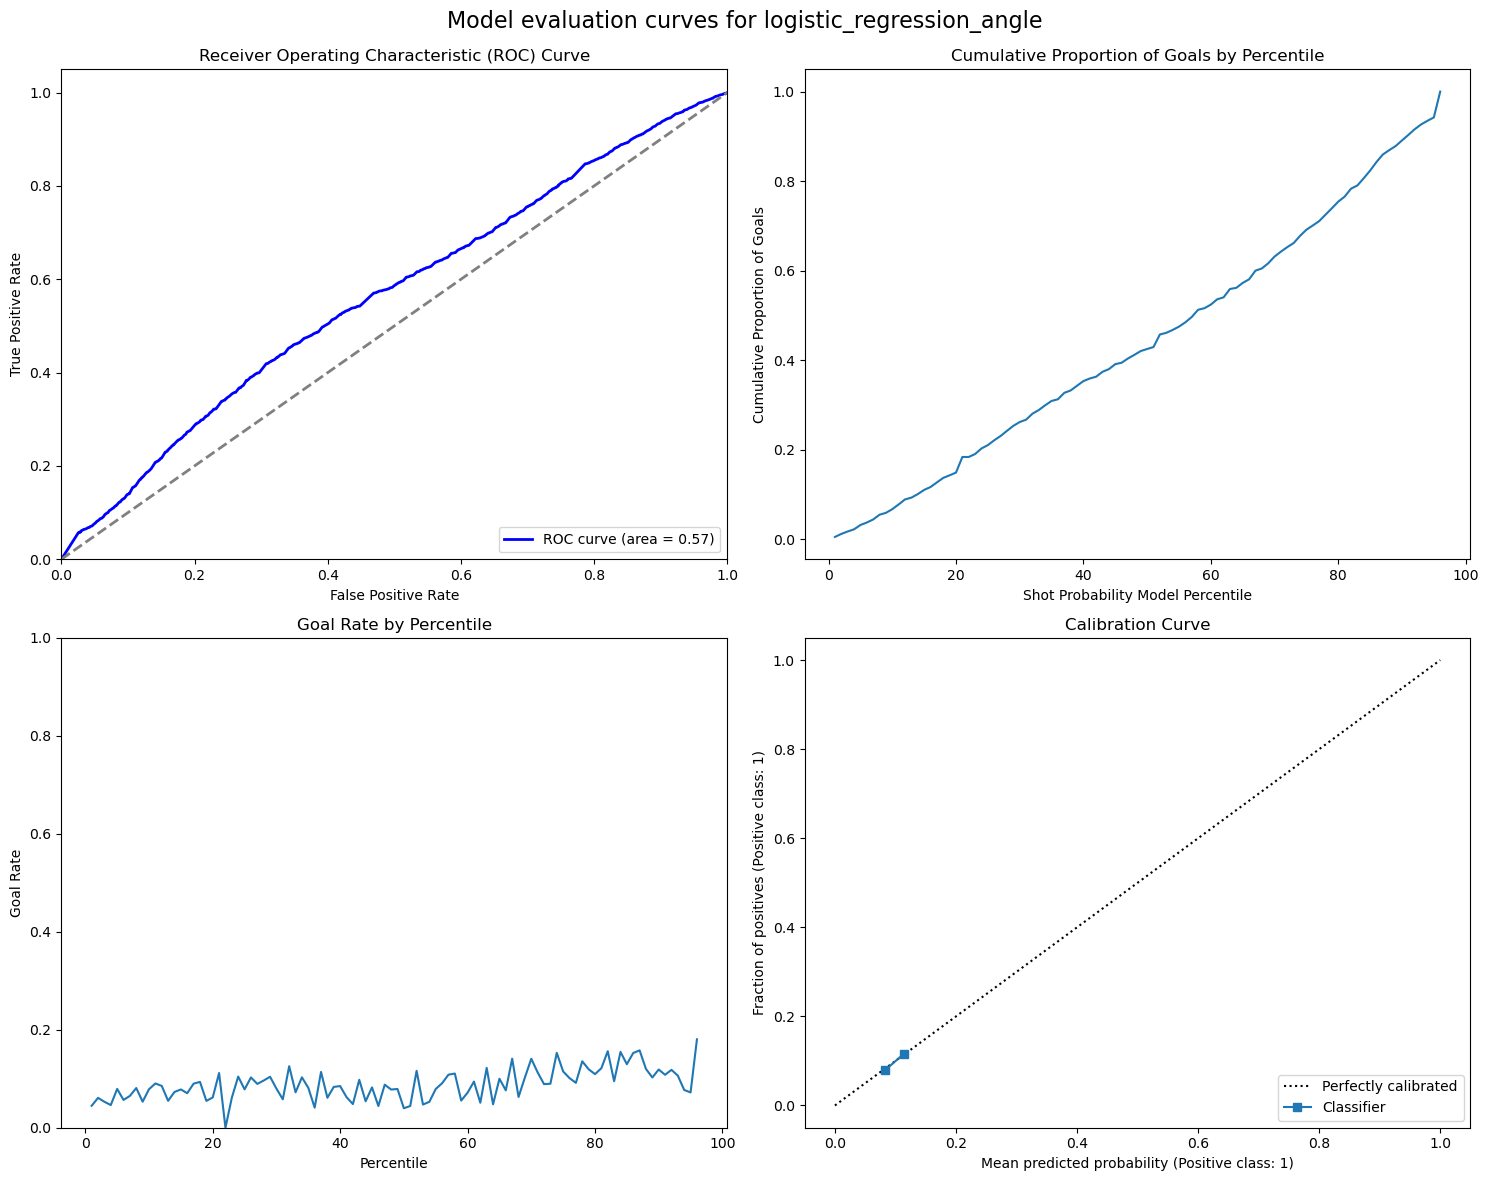

In [4]:
features = ['angle']
model_distance = LogisticRegression()
model_name = "logistic_regression_" + "_".join(features)
print(model_name)
model_handler = wandb_handler.ModelHandler()

X = df_train_val[features].to_numpy().reshape(-1, 1)
y = df_train_val['is_goal'].to_numpy().reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model_distance.fit(X_train, y_train)
model_handler.dump(model=model_distance, model_name=model_name)

y_pred_discrete, y_pred_proba = model_handler.predict(model_distance, X_val)

model_handler.log_wandb(model_name, X_val, y_val, features)

baseline_models_figures.plot_figures(y_pred_proba, y_val, model_name)


logistic_regression_distance_angle


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


c:\Users\dre\miniconda3\envs\ift-6758-lab-venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy,▁
auc,▁
f1_score,▁
precision,▁
recall,▁
accuracy,0.90621
auc,0.71409
f1_score,0
precision,0
recall,0


c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


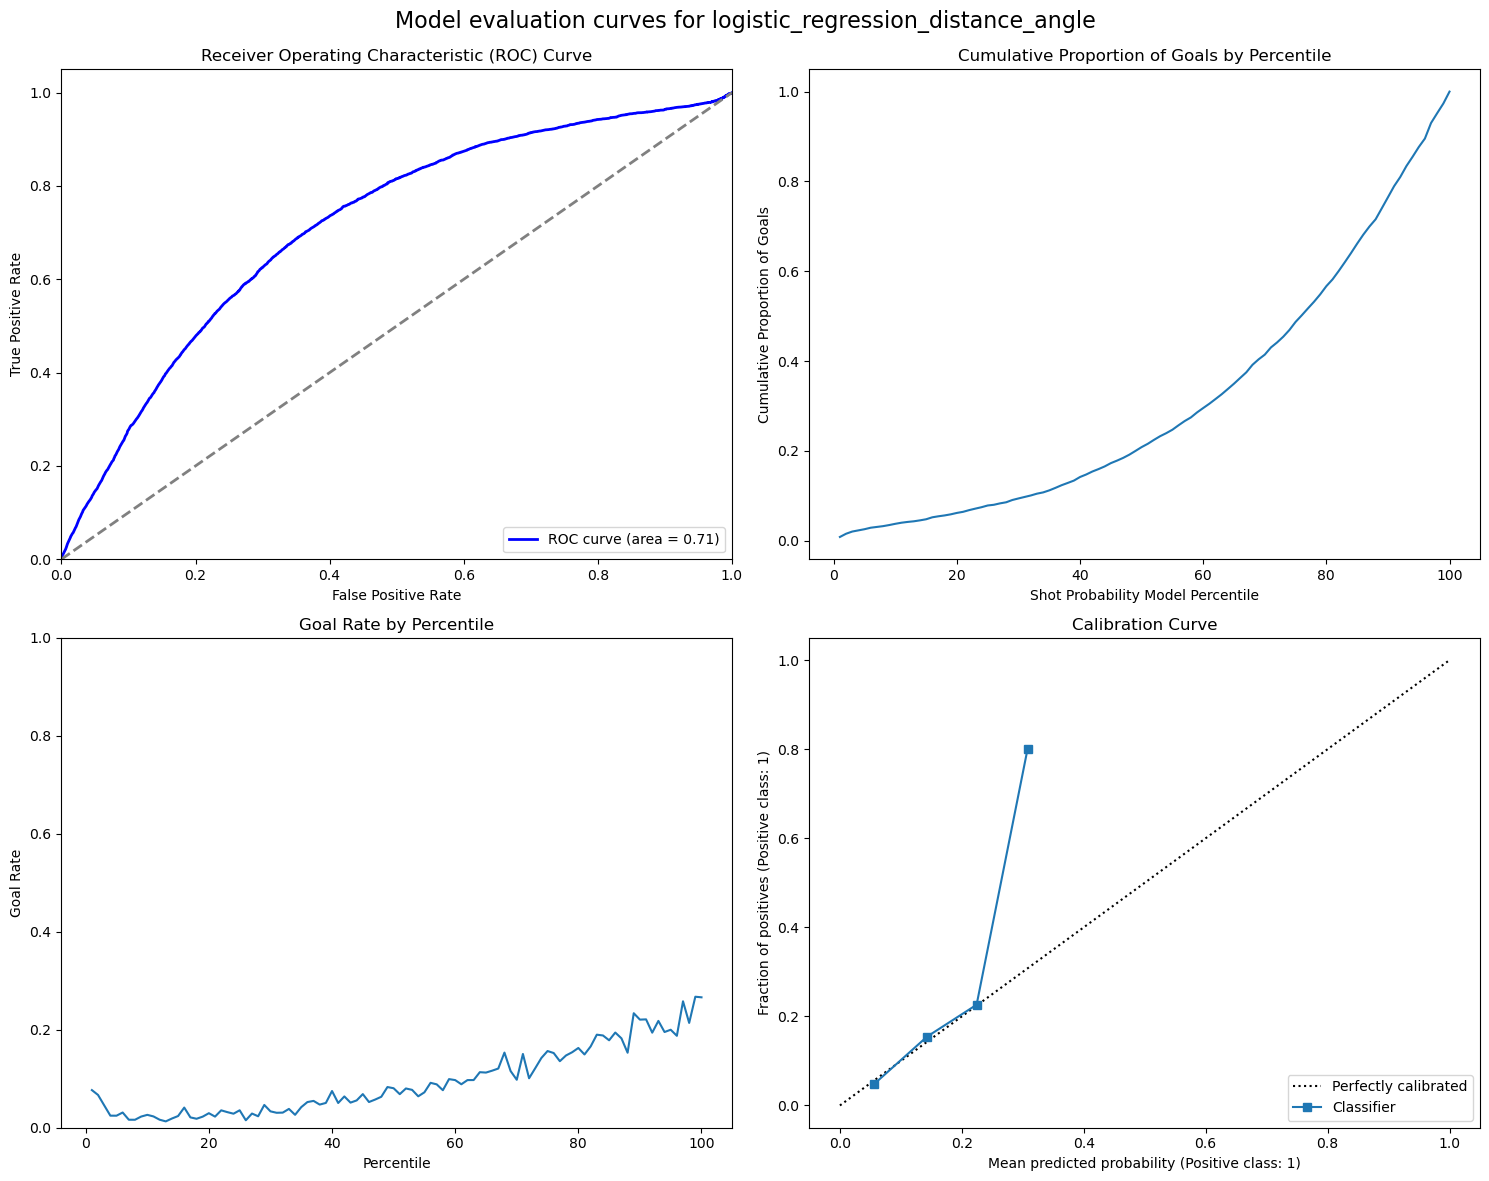

In [5]:
features = ['distance', 'angle']
model_distance = LogisticRegression()
model_name = "logistic_regression_" + "_".join(features)
print(model_name)
model_handler = wandb_handler.ModelHandler()

X = df_train_val[features].to_numpy()
y = df_train_val['is_goal'].to_numpy().reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model_distance.fit(X_train, y_train)
model_handler.dump(model=model_distance, model_name=model_name)

y_pred_discrete, y_pred_proba = model_handler.predict(model_distance, X_val)
model_handler.get_metrics(y_pred_discrete, y_pred_proba, y_val)

model_handler.log_wandb(model_name, X_val, y_val, features)

baseline_models_figures.plot_figures(y_pred_proba, y_val, model_name)


c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\visualizations\baseline_models_figures.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


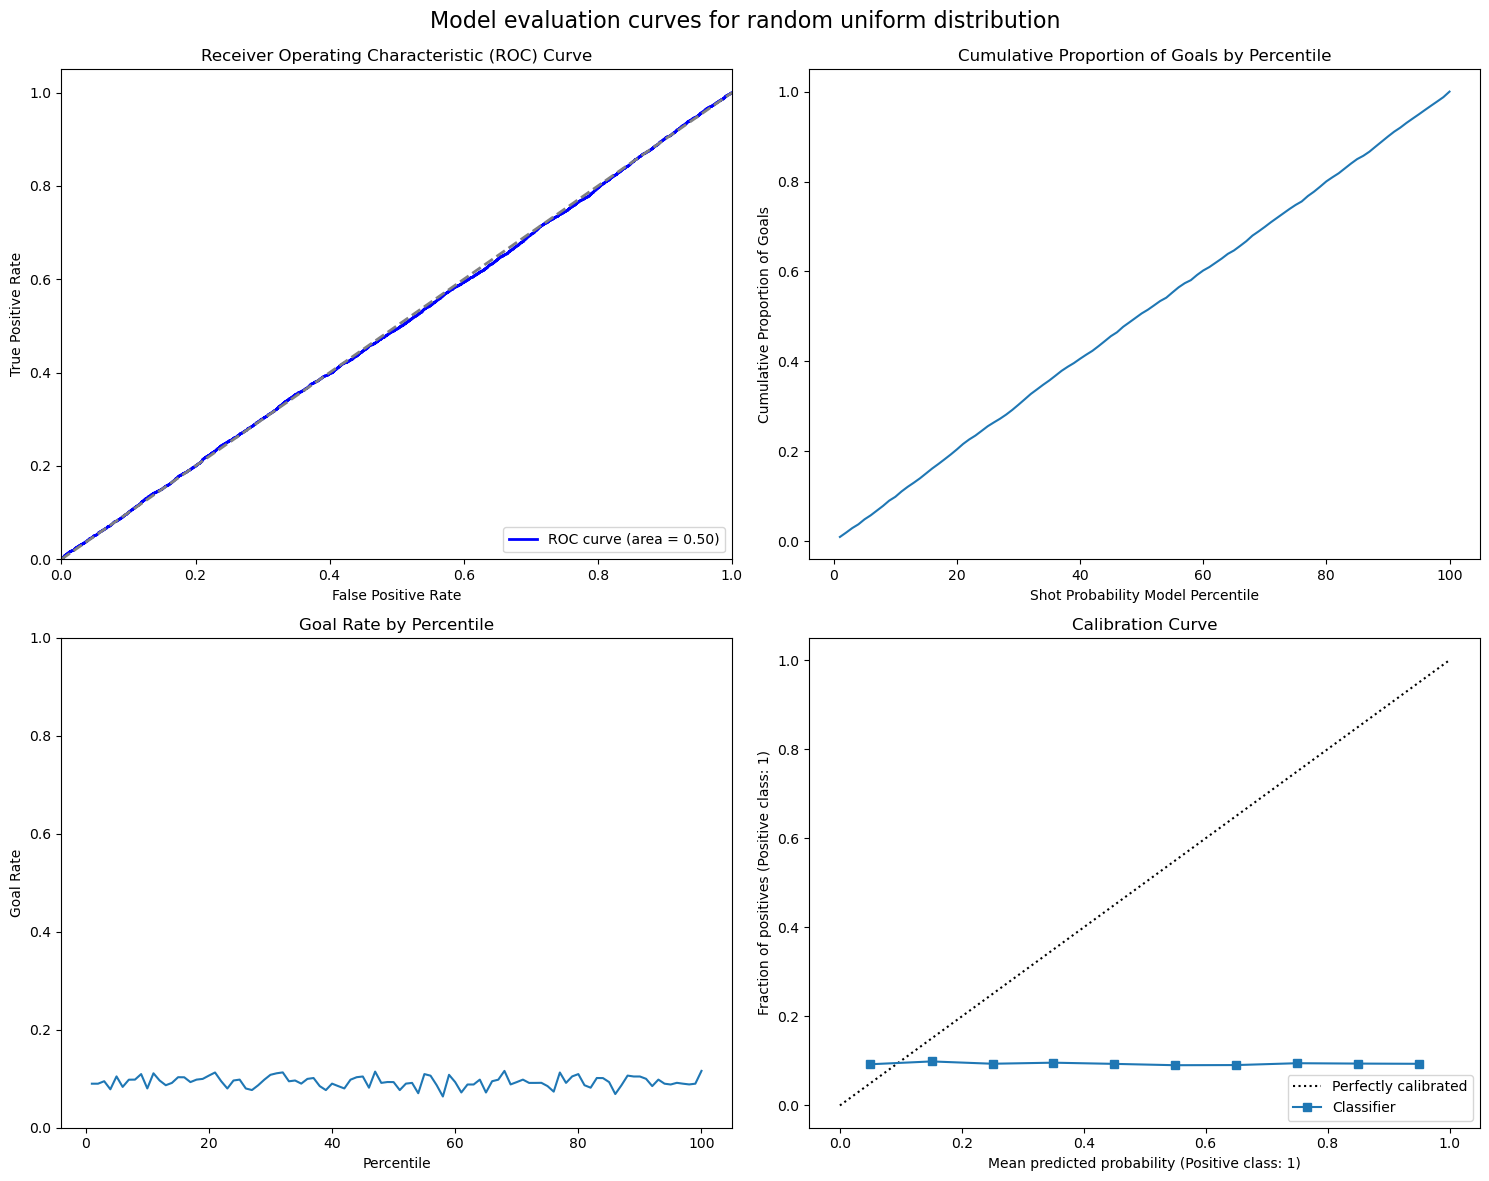

In [7]:
y_pred_proba_random = np.random.uniform(0, 1, size=y_val.shape)
y_pred_discrete_random = np.round(y_pred_proba_random)
y_pred_proba_random = np.hstack((1 - y_pred_proba_random, y_pred_proba_random)) # create probabilities for both classes to mimic the output of the logistic regression model and be able to use the same plotting function
baseline_models_figures.plot_figures(y_pred_proba_random,  y_val, "random uniform distribution")